# Imports

In [ ]:
# ============================================================================
# 03_modeling.ipynb
# Modeling and Evaluation for Diabetes Binary Classification
# Extended with Hyperparameter Tuning, Multiple Models, ANN, and Cost-Benefit Analysis
# Integrated with preprocessing module
# ============================================================================
"""
Notes:
- RandomizedSearchCV is used for efficiency.
- For expensive models (RF, XGBoost) tuning runs on a 30% subsample, then the best estimator is refit on the full training set.
- CV for RandomizedSearchCV is set to cv=5 as requested.
- MLP tuning uses early stopping and reduced max_iter for speed.
- Best models are saved to disk for use in 04_results.py
"""

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

from scipy.stats import randint, uniform

from pyexpat import features

# Add src directory to Python path to import preprocessing module
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, project_root)

# Import preprocessing module
try:
    from dpp.preprocessing import get_preprocessed_data
    PREPROCESSING_AVAILABLE = True
except ImportError as e:
    PREPROCESSING_AVAILABLE = False
    print(f"Warning: Could not import preprocessing module. Error: {e}")
    print("Using placeholder data for demonstration.")

# Load Preprocessed Data

In [14]:
# ============================================================================
# 1. LOAD PREPROCESSED DATA
# ============================================================================
print("="*80)
print("LOAD PREPROCESSED DATA")
print("="*80)

if PREPROCESSING_AVAILABLE:
    # Load preprocessed data from preprocessing module
    try:
        data = get_preprocessed_data()
        features_train = data['features_train']
        target_train = data['target_train']
        features_test = data['features_test']
        target_test = data['target_test']

        print(f"Training set size: {len(features_train):,}")
        print(f"Test set size: {len(features_test):,}")
        print(f"Number of features: {features_train.shape[1]}")
    except Exception as e:
        print(f"Error loading preprocessed data: {e}")
        print("Using placeholder data for demonstration.")
        PREPROCESSING_AVAILABLE = False
else:
    print("Preprocessing module not available.")

LOAD PREPROCESSED DATA
[preprocessing] Loading data from: C:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\DPP-Stackfuel-Data-Science-Projekt\data\raw\diabetes-health-indicators-dataset\diabetes_binary_health_indicators_BRFSS2015.csv
Training set size: 311,002
Test set size: 45,895
Number of features: 24


# Model Initialization

In [15]:
# ============================================================================
# 2. MODEL INITIALIZATION (base estimators)
# ============================================================================
print("\n" + "="*80)
print("MODEL INITIALIZATION (BASE ESTIMATORS)")
print("="*80)

base_estimators = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    # Use LinearSVC as base; wrap in CalibratedClassifierCV later if you need probabilities
    'SVM': CalibratedClassifierCV(LinearSVC(random_state=42, max_iter=10000, dual=False), cv=5),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500)
}



MODEL INITIALIZATION (BASE ESTIMATORS)


# Hyperparameter Tuning

In this section, hyperparameter tuning is performed only for four selected models:
Random Forest, XGBoost, Logistic Regression, and Neural Network.

The rationale behind this selective tuning approach is based on a balance between 
computational efficiency and expected impact on model performance:

1. Effectiveness of Hyperparameters:
   These four models have hyperparameters that significantly influence their 
   predictive performance. For example, the number of trees and depth in Random Forest,
   learning rate and tree depth in XGBoost, regularization strength in Logistic Regression,
   and architecture parameters in Neural Networks can greatly affect results.

2. Computational Cost:
   Exhaustive hyperparameter tuning (e.g., GridSearchCV) is computationally expensive,
   especially when applied to many models with large parameter grids. Focusing on 
   models with the highest potential gain optimizes resource usage.

3. Simplicity and Speed of Other Models:
   Other models like Decision Trees, K-Nearest Neighbors, Naive Bayes, and Linear SVM 
   typically have fewer or less impactful hyperparameters, or are inherently faster to train.
   Their default parameters often provide reasonable baseline performance.

4. Practical Workflow:
   This approach allows for a manageable and efficient modeling pipeline, prioritizing 
   tuning efforts where they are most likely to yield substantial improvements.

If desired, hyperparameter tuning can be extended to additional models using more 
efficient search strategies (e.g., RandomizedSearchCV) or by tuning a smaller subset 
of parameters to balance performance gains with computational cost.


In [16]:
# ============================================================================
# 3. HYPERPARAMETER TUNING (RandomizedSearchCV, CV=5)
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("Note: Tuning for expensive models (RF, XGB) runs on a 30% subsample to save time.")
print("="*80)

# Create a 30% subsample for expensive model tuning
features_sub, _, target_sub, _ = train_test_split(features_train, target_train, train_size=0.30, stratify=target_train, random_state=42)

# Parameter distributions for RandomizedSearch
param_distributions = {
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [8, 12, 20, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2', 0.5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': [None, 'balanced']
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
}

# We will store the final trained models here
trained_models = {}




HYPERPARAMETER TUNING
Note: Tuning for expensive models (RF, XGB) runs on a 30% subsample to save time.


In [17]:
# Helper function to run RandomizedSearchCV and refit best estimator on full training set
def tune_and_refit(name, estimator, param_dist, features_tune, target_tune, features_full, target_full, n_iter=20, cv=5):
    """
    Tune estimator with RandomizedSearchCV on features_tune/target_tune (subsample for speed),
    then refit the best estimator on the full training data features_full/target_full.
    Returns the refitted best estimator and the best CV score.
    """
    print(f"[tuning] {name}: Starting RandomizedSearchCV (n_iter={n_iter}, cv={cv}) ...")
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    t0 = time.time()
    rs.fit(features_tune, target_tune)
    t1 = time.time()
    print(f"[tuning] {name}: RandomizedSearchCV finished in {(t1-t0)/60:.2f} min. Best CV score: {rs.best_score_:.4f}")
    print(f"[tuning] {name}: Best params: {rs.best_params_}")

    # Refit best estimator on full training data for final model
    best_est = rs.best_estimator_
    print(f"[tuning] {name}: Refitting best estimator on the full training set ...")
    t2 = time.time()
    best_est.fit(features_full, target_full) # pyright: ignore[reportAttributeAccessIssue]
    t3 = time.time()
    print(f"[tuning] {name}: Refit finished in {(t3-t2)/60:.2f} min.")
    return best_est, rs.best_score_



In [18]:
# Tuning loop for selected models
#tuned_models = {}
#tuned_scores = {}

# Random Forest tuning (on subsample, then refit on full)
if 'Random Forest' in base_estimators:
    rf_est = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_param_dist = param_distributions['Random Forest']
    best_rf, best_rf_score = tune_and_refit('Random Forest', rf_est, rf_param_dist, features_sub, target_sub, features_train, target_train, n_iter=20, cv=5)
    trained_models['Random Forest'] = best_rf
    #tuned_scores['Random Forest'] = best_rf_score



[tuning] Random Forest: Starting RandomizedSearchCV (n_iter=20, cv=5) ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[tuning] Random Forest: RandomizedSearchCV finished in 15.12 min. Best CV score: 0.9598
[tuning] Random Forest: Best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': None}
[tuning] Random Forest: Refitting best estimator on the full training set ...
[tuning] Random Forest: Refit finished in 0.63 min.


In [19]:
# XGBoost tuning (if available)
if 'XGBoost' in param_distributions:
    xgb_est = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb_param_dist = param_distributions['XGBoost']
    best_xgb, best_xgb_score = tune_and_refit('XGBoost', xgb_est, xgb_param_dist, features_sub, target_sub, features_train, target_train, n_iter=20, cv=5)
    trained_models['XGBoost'] = best_xgb
    #tuned_scores['XGBoost'] = best_xgb_score



[tuning] XGBoost: Starting RandomizedSearchCV (n_iter=20, cv=5) ...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[tuning] XGBoost: RandomizedSearchCV finished in 2.34 min. Best CV score: 0.9635
[tuning] XGBoost: Best params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
[tuning] XGBoost: Refitting best estimator on the full training set ...
[tuning] XGBoost: Refit finished in 0.16 min.


In [20]:
# Logistic Regression tuning
if 'Logistic Regression' in param_distributions:
    lr_est = LogisticRegression(random_state=42, max_iter=1000)
    lr_param_dist = param_distributions['Logistic Regression']
    best_lr, best_lr_score = tune_and_refit('Logistic Regression', lr_est, lr_param_dist, features_sub, target_sub, features_train, target_train, n_iter=20, cv=5)
    trained_models['Logistic Regression'] = best_lr
    #tuned_scores['Logistic Regression'] = best_lr_score



[tuning] Logistic Regression: Starting RandomizedSearchCV (n_iter=20, cv=5) ...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[tuning] Logistic Regression: RandomizedSearchCV finished in 22.87 min. Best CV score: 0.8135
[tuning] Logistic Regression: Best params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 0.1}
[tuning] Logistic Regression: Refitting best estimator on the full training set ...
[tuning] Logistic Regression: Refit finished in 0.05 min.


In [21]:
# --- Neural Network tuning (MLP), FASTER VERSION ---
# Use a 30% subsample for tuning, enable early stopping, reduce max_iter, and reduce n_iter
if 'Neural Network' in param_distributions:
    # Subsample for MLP tuning
    features_sub_nn, _, target_sub_nn, _ = train_test_split(features_train, target_train, train_size=0.30, stratify=target_train, random_state=42)

    # Base estimator with early stopping and reduced iterations for tuning
    nn_est = MLPClassifier(random_state=42, max_iter=200, early_stopping=True, n_iter_no_change=10)

    nn_param_dist = param_distributions['Neural Network']

    # Randomized search with fewer iterations (n_iter=10) and cv=5
    best_nn, best_nn_score = tune_and_refit('Neural Network', nn_est, nn_param_dist, features_sub_nn, target_sub_nn, features_train, target_train, n_iter=10, cv=5)
    trained_models['Neural Network'] = best_nn
    



[tuning] Neural Network: Starting RandomizedSearchCV (n_iter=10, cv=5) ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[tuning] Neural Network: RandomizedSearchCV finished in 18.19 min. Best CV score: 0.9196
[tuning] Neural Network: Best params: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
[tuning] Neural Network: Refitting best estimator on the full training set ...
[tuning] Neural Network: Refit finished in 2.05 min.


In [22]:
# For any remaining models not tuned, fit defaults on the full training set
for name, est in base_estimators.items():
    if name in trained_models:
        continue
    if est is None:
        continue
    print(f"[fit-default] Fitting default estimator for {name} on full training set ...")
    t0 = time.time()
    est.fit(features_train, target_train)
    t1 = time.time()
    print(f"[fit-default] {name} fitted in {(t1-t0)/60:.2f} min.")
    trained_models[name] = est


[fit-default] Fitting default estimator for SVM on full training set ...
[fit-default] SVM fitted in 0.21 min.
[fit-default] Fitting default estimator for K-Nearest Neighbors on full training set ...
[fit-default] K-Nearest Neighbors fitted in 0.00 min.
[fit-default] Fitting default estimator for Decision Tree on full training set ...
[fit-default] Decision Tree fitted in 0.08 min.
[fit-default] Fitting default estimator for Naive Bayes on full training set ...
[fit-default] Naive Bayes fitted in 0.00 min.


# Model Evaluation

In [23]:
# ============================================================================
# 4. MODEL EVALUATION
# ============================================================================
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

model_results = {}
for name, model in trained_models.items():
    print(f"\nEvaluating {name} ...")
    # Ensure model supports predict_proba; if not, try to obtain calibrated probabilities
    try:
        y_proba = model.predict_proba(features_test)[:, 1]
    except Exception:
        # fallback: use decision_function and min-max scale (heuristic) - ideally calibrate with holdout
        if hasattr(model, "decision_function"):
            scores = model.decision_function(features_test)
            from sklearn.preprocessing import MinMaxScaler
            y_proba = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
        else:
            # last-resort: use predict (not ideal)
            y_proba = model.predict(features_test)

    y_pred = (y_proba >= 0.5).astype(int) if y_proba.ndim == 1 else model.predict(features_test)

    # Calculate all metrics
    auc_score = roc_auc_score(target_test, y_proba)
    precision = precision_score(target_test, y_pred)
    recall = recall_score(target_test, y_pred)
    f1 = f1_score(target_test, y_pred)
    accuracy = accuracy_score(target_test, y_pred)

    cv_scores = cross_val_score(model, features_train, target_train, cv=5, scoring='roc_auc', n_jobs=-1)

    model_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"AUC Score: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV AUC Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Identify best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['auc'])
best_model = model_results[best_model_name]['model']
best_y_proba = model_results[best_model_name]['y_proba']

print(f"\nBest model: {best_model_name} with AUC: {model_results[best_model_name]['auc']:.4f}")


MODEL EVALUATION

Evaluating Random Forest ...
AUC Score: 0.7887
Precision: 0.4673
Recall: 0.2402
F1 Score: 0.3173
Accuracy: 0.8419
CV AUC Score: 0.9751 (+/- 0.0906)

Evaluating XGBoost ...
AUC Score: 0.8153
Precision: 0.5562
Recall: 0.2177
F1 Score: 0.3129
Accuracy: 0.8538
CV AUC Score: 0.9511 (+/- 0.1847)

Evaluating Logistic Regression ...
AUC Score: 0.8078
Precision: 0.3185
Recall: 0.7550
F1 Score: 0.4480
Accuracy: 0.7155
CV AUC Score: 0.8155 (+/- 0.0115)

Evaluating Neural Network ...
AUC Score: 0.7897
Precision: 0.4167
Recall: 0.4085
F1 Score: 0.4125
Accuracy: 0.8221
CV AUC Score: 0.9234 (+/- 0.1606)

Evaluating SVM ...
AUC Score: 0.8075
Precision: 0.3181
Recall: 0.7532
F1 Score: 0.4473
Accuracy: 0.7153
CV AUC Score: 0.8152 (+/- 0.0116)

Evaluating K-Nearest Neighbors ...
AUC Score: 0.7070
Precision: 0.2678
Recall: 0.6293
F1 Score: 0.3758
Accuracy: 0.6802
CV AUC Score: 0.9198 (+/- 0.0120)

Evaluating Decision Tree ...
AUC Score: 0.5901
Precision: 0.2792
Recall: 0.3342
F1 Score: 

# Saving Best Models

In [24]:
# ============================================================================
# 5. SAVE BEST MODELS
# ============================================================================
print("\n" + "="*80)
print("SAVE BEST MODELS")
print("="*80)

# Create models directory if it doesn't exist
models_dir = os.path.join(project_root, 'models')
os.makedirs(models_dir, exist_ok=True)

# Save all trained models
for name, model in trained_models.items():
    model_path = os.path.join(models_dir, f"{name.replace(' ', '_')}_model.pkl")
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

# Save model results for use in 04_results.py
results_path = os.path.join(models_dir, 'model_results.pkl')
joblib.dump(model_results, results_path)
print(f"Saved model results to {results_path}")


SAVE BEST MODELS
Saved Random Forest model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\Random_Forest_model.pkl
Saved XGBoost model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\XGBoost_model.pkl
Saved Logistic Regression model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\Logistic_Regression_model.pkl
Saved Neural Network model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\Neural_Network_model.pkl
Saved SVM model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\SVM_model.pkl
Saved K-Nearest Neighbors model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\K-Nearest_Neighbors_model.pkl
Saved Decision Tree model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\Decision_Tree_model.pkl
Saved Naive Bayes model to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\Naive_Bayes_model.pkl
Saved model results to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\model_results.pkl


# Diabetes Detection (Class 1)


FOCUS ON DIABETES DETECTION (CLASS 1)


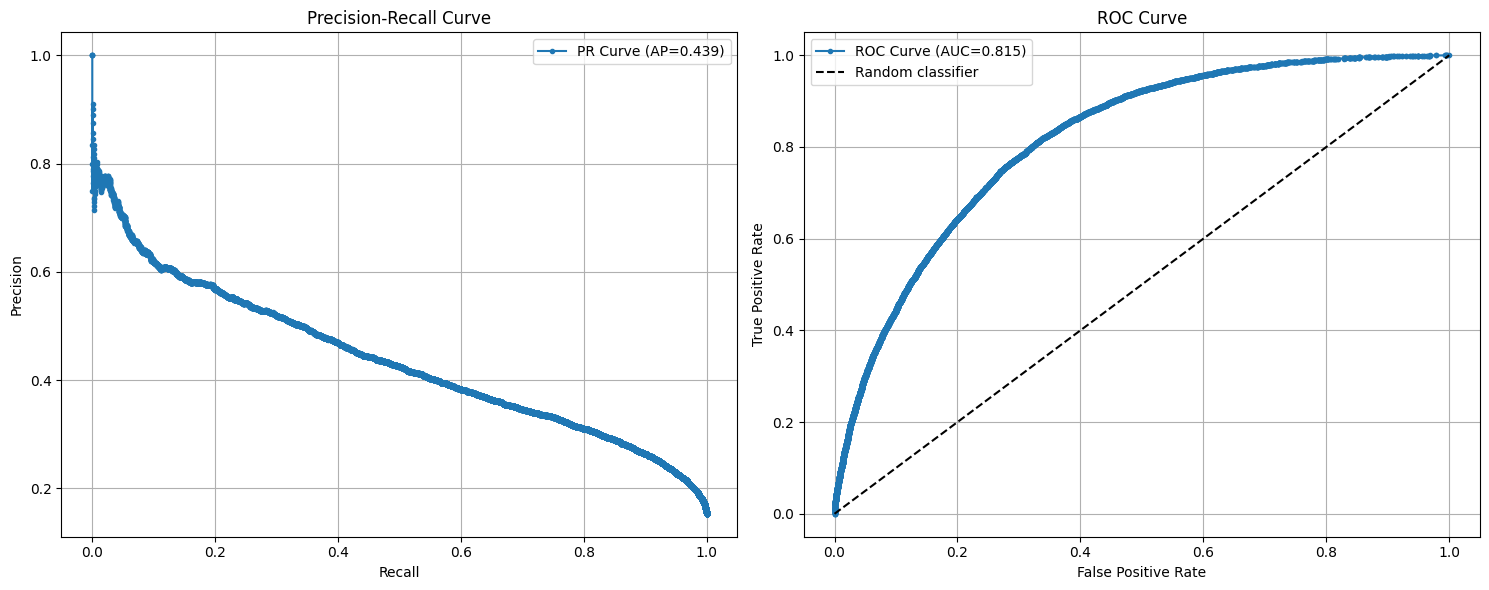

Model evaluation curves saved as '03_model_evaluation_curves.png'


In [26]:
# ============================================================================
# 6. FOCUS ON DIABETES DETECTION (CLASS 1)
# ============================================================================
print("\n" + "="*80)
print("FOCUS ON DIABETES DETECTION (CLASS 1)")
print("="*80)

precision, recall, thresholds_pr = precision_recall_curve(target_test, best_y_proba)
avg_precision = average_precision_score(target_test, best_y_proba)
fpr, tpr, thresholds_roc = roc_curve(target_test, best_y_proba)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.', label=f'PR Curve (AP={avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC={model_results[best_model_name]["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('03_model_evaluation_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model evaluation curves saved as '03_model_evaluation_curves.png'")

# Cost-Benefit Analysis


DECISION CURVE ANALYSIS (DCA)
Optimal threshold (max net benefit): 0.010
Maximum net benefit (DCA): 0.144803


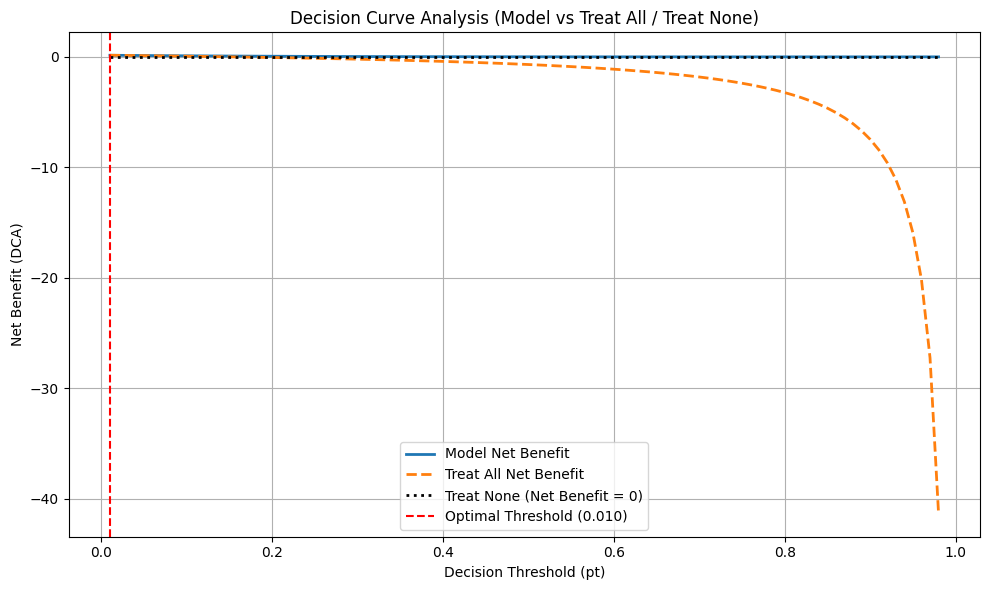

Decision Curve Analysis plot saved as '03_decision_curve_analysis.png'

Confusion matrix at optimal threshold:
[[ 4199 34677]
 [   23  6996]]
DCA results saved to c:\Users\Eyyub\Desktop\StackFuel\PortfolioProjekt\models\dca_results.pkl


In [30]:
# ============================================================================
# 7. COST-BENEFIT ANALYSIS
# ============================================================================
"""
Decision Curve Analysis (DCA) — explanation and usage.

DCA purpose
-----------
Decision Curve Analysis (DCA) is a method to evaluate the clinical usefulness of
a diagnostic or predictive model across a range of decision thresholds without
requiring explicit monetary valuations. DCA computes a 'net benefit' for each
threshold (probability cut-off) that reflects the trade-off between true
positives and false positives at that threshold.

DCA formula
-----------
For a given threshold pt, and sample size N:
    net_benefit(pt) = (TP / N) - (FP / N) * (pt / (1 - pt))

Interpretation
--------------
- TP: number of true positives at threshold pt
- FP: number of false positives at threshold pt
- The factor (pt / (1 - pt)) is the odds at threshold pt and represents the relative
  weight of a false positive compared to a true positive implied by choosing pt.
- Net benefit is measured in "true positives per patient" scaled by the threshold
  weights; it is not a monetary value.
- A model is clinically useful at a threshold pt if its net benefit is higher
  than the net benefit of the two default strategies:
    - Treat none (net benefit = 0)
    - Treat all (net benefit computed by assuming everyone is treated)

Practical notes
---------------
- Use DCA when you care about the clinical decision trade-offs (e.g. whether to
  refer for further testing, start treatment) and you want a threshold-agnostic view.
- DCA does NOT replace domain-specific judgement. Report thresholds of interest
  and, if desired, supplement with sensitivity analyses.
- This implementation additionally plots the 'treat all' and 'treat none'
  strategies for comparison, and returns the threshold with the maximum net benefit.
"""
print("\n" + "="*80)
print("DECISION CURVE ANALYSIS (DCA)")
print("="*80)

# Compute DCA net benefit for a model's predicted probabilities
def compute_decision_curve(y_true, y_proba, thresholds):
    """
    Compute net benefit for each threshold following DCA formula.

    Args:
        y_true (array-like): true binary labels (0/1).
        y_proba (array-like): predicted probabilities for the positive class.
        thresholds (array-like): list/array of thresholds to evaluate.

    Returns:
        dict: {
            'thresholds': thresholds (np.array),
            'net_benefits': np.array of model net benefits,
            'net_benefit_treat_all': np.array of treat-all net benefits,
            'net_benefit_treat_none': np.array of treat-none net benefits (zeros)
        }
    """
    N = len(y_true)
    net_benefits = []
    net_benefits_all = []
    net_benefits_none = []

    # Precompute counts for the treat-all strategy
    # If we "treat all", TP = number of positives, FP = number of negatives
    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)

    for pt in thresholds:
        # Predicted positive/negative labels at threshold pt
        y_pred = (y_proba >= pt).astype(int)

        # Confusion matrix values: tn, fp, fn, tp
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # DCA net benefit for the model at pt
        # Formula: (TP / N) - (FP / N) * (pt / (1 - pt))
        weight = pt / (1.0 - pt)
        nb_model = (tp / N) - (fp / N) * weight
        net_benefits.append(nb_model)

        # DCA net benefit for the treat-all strategy at pt
        nb_all = (total_positives / N) - (total_negatives / N) * weight
        net_benefits_all.append(nb_all)

        # Treat-none has net benefit = 0 for all thresholds
        net_benefits_none.append(0.0)

    return {
        'thresholds': np.array(thresholds),
        'net_benefits': np.array(net_benefits),
        'net_benefit_treat_all': np.array(net_benefits_all),
        'net_benefit_treat_none': np.array(net_benefits_none)
    }

# Range of thresholds to evaluate (fine grid)
thresholds_to_test = np.arange(0.01, 0.99, 0.01)

# Compute decision curves using the best model probabilities (best_y_proba) and test labels (target_test)
dca_results = compute_decision_curve(target_test, best_y_proba, thresholds_to_test)

# Find optimal threshold that maximizes net benefit for the model
optimal_idx = np.nanargmax(dca_results['net_benefits'])
optimal_threshold = dca_results['thresholds'][optimal_idx]
optimal_net_benefit = dca_results['net_benefits'][optimal_idx]

print(f"Optimal threshold (max net benefit): {optimal_threshold:.3f}")
print(f"Maximum net benefit (DCA): {optimal_net_benefit:.6f}")

# Plot Decision Curve: model vs treat-all vs treat-none
plt.figure(figsize=(10, 6))
plt.plot(dca_results['thresholds'], dca_results['net_benefits'],
         label='Model Net Benefit', color='C0', linewidth=2)
plt.plot(dca_results['thresholds'], dca_results['net_benefit_treat_all'],
         label='Treat All Net Benefit', color='C1', linestyle='--', linewidth=2)
plt.plot(dca_results['thresholds'], dca_results['net_benefit_treat_none'],
         label='Treat None (Net Benefit = 0)', color='k', linestyle=':', linewidth=2)

# Mark optimal threshold on the plot
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')

plt.xlabel('Decision Threshold (pt)')
plt.ylabel('Net Benefit (DCA)')
plt.title('Decision Curve Analysis (Model vs Treat All / Treat None)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save the DCA plot
plt.savefig('03_decision_curve_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Decision Curve Analysis plot saved as '03_decision_curve_analysis.png'")

# Print confusion matrix at optimal threshold for interpretability
y_pred_optimal = (best_y_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(target_test, y_pred_optimal)
print("\nConfusion matrix at optimal threshold:")
print(cm_optimal)

# Save the optimal threshold and DCA results into the models/results folder
models_dir = os.path.join(project_root, 'models')
os.makedirs(models_dir, exist_ok=True)
dca_save_path = os.path.join(models_dir, 'dca_results.pkl')

# Save a compact DCA summary (thresholds, net_benefits, optimal threshold)
joblib.dump({
    'thresholds': dca_results['thresholds'],
    'net_benefits': dca_results['net_benefits'],
    'net_benefit_treat_all': dca_results['net_benefit_treat_all'],
    'optimal_threshold': float(optimal_threshold),
    'optimal_net_benefit': float(optimal_net_benefit)
}, dca_save_path)
print(f"DCA results saved to {dca_save_path}")